在这个教程中，你将会学到怎么用路网和行政区划数据生成地块矢量

<div class="alert alert-info"><h2>提供的基础数据是：</h2><p>

<br>
    GIS文件：<br>
    1.深圳行政区划<br>
    2.深圳路网<br>


</div>

# 读取数据

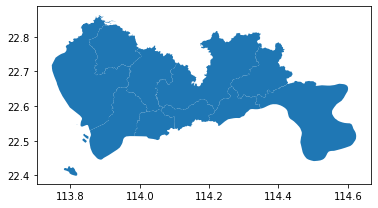

In [75]:
#导入必要的包
import pandas as pd
import numpy as np

#绘制图用的包
import matplotlib as mpl
import matplotlib.pyplot as plt

#geopandas包
import geopandas

#shapely包
from shapely.geometry import Point,Polygon,shape

#读取shapefile文件
shp = r'shapefile/sz.shp'
sz = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')

#绘制看看长什么样
sz.plot()

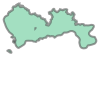

In [76]:
#将深圳合并为一个单一的shapely geometry
sz = sz.unary_union
sz

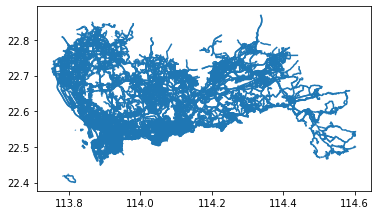

In [77]:
#路网
shp = r'shapefile/shenzhen_osmroad.shp'
road = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')

#绘制看看长什么样
road.plot()

# 开始

首先我们将路网的线和行政区划的面的边界组合到一起

In [78]:
lines = list(road['geometry'])+list(sz.boundary)

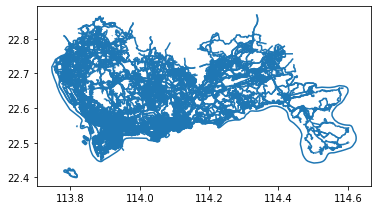

In [79]:
geopandas.GeoDataFrame({'geometry':lines}).plot()

用上面的线段构成面

In [80]:
import shapely
#第一个操作：把相邻的线合成到一起，即A的起点和B终点在同一个位置，那么把AB合成一起（如果不这样做，后面得到的结果可能会在AB端点处打断，但AB端点不一定是交点）
merged_lines = shapely.ops.linemerge(lines)
#第二个操作：合并为整体，但是实际上是线段的组合，会在交点处打断
border_lines = shapely.ops.unary_union(merged_lines)
#上面两个操作连起来实现的功能就是在交点处打断线
#第三个操作：生成线段所组成的面
decomposition = shapely.ops.polygonize_full(border_lines)

decomposition这个东西实际上生成的是四个东西,第一个东西是切割出来的面

In [95]:
decomposition

(<shapely.geometry.collection.GeometryCollection at 0x1f4d58ddc18>,
 <shapely.geometry.collection.GeometryCollection at 0x1f4d58ddbe0>)

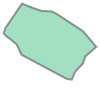

In [101]:
decomposition[0][0]

把面搞成一个geodataframe

In [81]:
area = geopandas.GeoDataFrame({'geometry':list(decomposition[0])})

这里我们遇到一个问题，就是道路是有宽度的，但是反映在osm上面就是一条线，没有宽度。  
而一条快速路又可能会由几条平行的线组成，这样切分出来的快速路也会形成面  
但是，我们想要的是，路围成的地块的面  
这里我采用的方法是，反向buffer一个道路的宽度，这样切分出来的快速路的面因为是条状的，buffer一下就没了；地块则会被保留  
试一下，反向buffer0.00015

In [ ]:
###############################你需要在下面写代码##################################
#反向buffer0.00015
#生成一个新的gdf叫area1

###################################################################################

In [82]:
###############################     答    案    ##################################
area1 = area.buffer(-0.00015)
#经纬度的1°大约等于111.111km，也就是说
#这里设定的0.00015大约是
#0.00015*1000*111.111 = 16.66665m

#接下来把buffer一下就没了的面删除
area1 = area1[-area1.is_empty]

#生成一个新的gdf
area1 = geopandas.GeoDataFrame({'geometry':area1})
###################################################################################

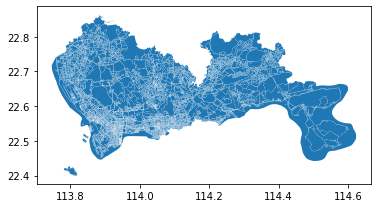

In [85]:
area1.plot()

提取每个地块的中心点

In [ ]:
###############################你需要在下面写代码##################################
#生成一个新的gdf叫areacentroid
#存储这些地块的中心点

###################################################################################

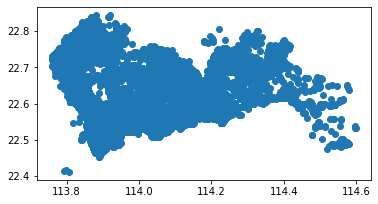

In [107]:
###############################     答    案    ##################################
areacentroid = area1.copy()
areacentroid['geometry'] = area1.centroid
areacentroid.plot()

###################################################################################

# 可视化!

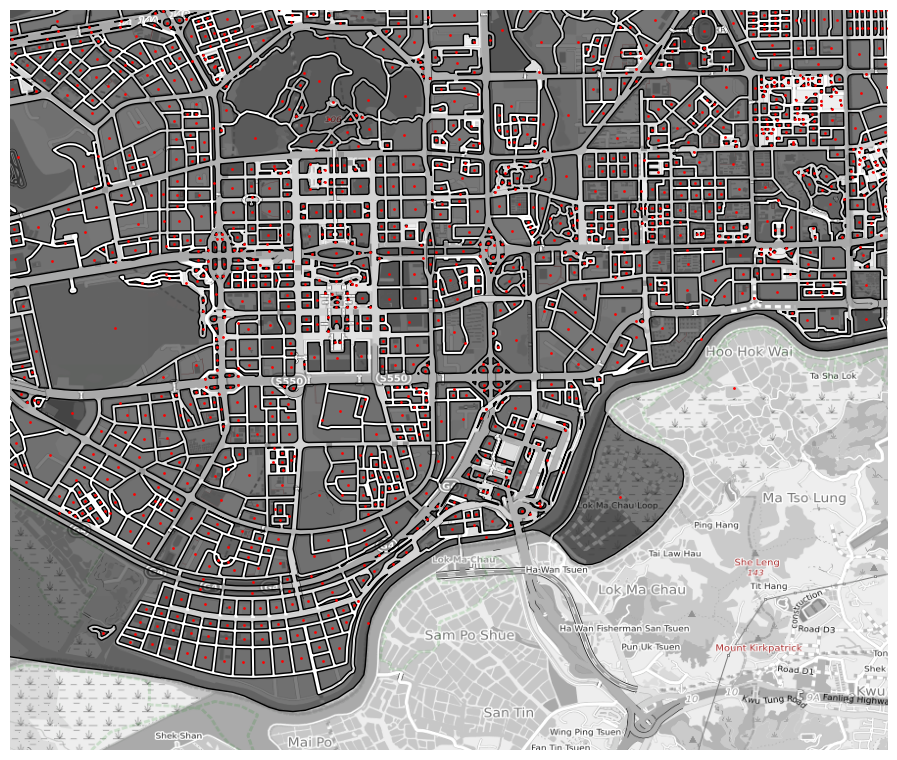

In [118]:
#放大看看
lat1sh = 22.499;
lat2sh = 22.564;
lon1sh = 114.026;
lon2sh = 114.103;
bounds = [lon1sh,lat1sh,lon2sh,lat2sh]

import matplotlib as mpl
import matplotlib.pyplot as plt
import plot_map
import seaborn as sns
fig     = plt.figure(1,(10,10),dpi = 100)      
ax      = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect = (0.05,0.1,1,0.9))

#背景
plot_map.plot_map(plt,bounds,zoom = 14,style = 4)

#绘制地块
area1.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0.5))
#绘制地块中心点
areacentroid.plot(ax = ax,markersize = 1,color = 'red')


plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])

plt.show()


如果你不需要道路范围外的那些地方，也可以不输入行政区划的边界  
下一步，你就可以把GPS数据，POI数据等等用sjoin对应上去地块做一些骚操作拉

# 思考一下

切分地块出来得到的数据中，还是有一些道路交叉口或者道路中心线之间围成的区域  
这些区域是否有可能识别出来删掉呢？